# Basic tutorial

The next cell just creates the default configs and folders if they aren't already present.
You normally shouldn't need to do this, but if you want to "factory reset" to the defaults pytti ships with, delete the `config/` directory and run the following command. If you have config files, don't worry: it won't overwrite them. It'll just do nothing.

In [1]:
%%capture
!rm -rf config/
!rm -rf images_out/
!rm -rf outputs/
!python -m pytti.warmup


Next, we'll author a config *.yaml file containing the settings that describe the experiment we want to run.

The file needs to go in the `config/conf` subdirectory and can be named whatever we want. 

Under the current config system, the first line of the file needs to be: `# @package _global_`

After that, each setting goes on its own line. The order in which they appear does not matter, as long as each setting appears on a line of its own.

We'll start by specifying a text prompt and see what happens. We'll also specify a random seed as well, just to ensure the outputs are deterministic. This helps us understand exactly how changing a setting modifies the generated image.

In [2]:
%%writefile config/conf/my_first_pytti_art.yaml
# @package _global_
scenes: Everybody knows that the bird is the word
seed: 123

Writing config/conf/my_first_pytti_art.yaml


Next, we'll pass this config file to the CLI to generate an image using the `conf` argument. Note that the name of this argument is actually the name of the subfolder the file is in. See the "Usage" article for details on precisely what's going on here.

We just need to provide the CLI the name of the file without the `*.yaml` file extension.

In [3]:
!python -m pytti.workhorse conf=my_first_pytti_art

2022-02-19 18:45:34.646 | DEBUG    | pytti.warmup:<module>:13 - /home/dmarx/miniconda3/envs/sandbox/lib/python3.9/site-packages/pytti
2022-02-19 18:45:34.646 | DEBUG    | pytti.warmup:<module>:27 - /home/dmarx/miniconda3/envs/sandbox/lib/python3.9/site-packages/pytti
2022-02-19 18:45:34.646 | DEBUG    | pytti.warmup:ensure_configs_exist:43 - Local config directory detected.
2022-02-19 18:45:36.163 | INFO     | __main__:<module>:35 - Loading pytti...
2022-02-19 18:45:37.852 | INFO     | __main__:<module>:77 - pytti loaded.
2022-02-19 18:45:37.852 | DEBUG    | __main__:<module>:81 - ['/home/dmarx/proj/pytti-book', '/home/dmarx/miniconda3/envs/sandbox/lib/python39.zip', '/home/dmarx/miniconda3/envs/sandbox/lib/python3.9', '/home/dmarx/miniconda3/envs/sandbox/lib/python3.9/lib-dynload', '/home/dmarx/miniconda3/envs/sandbox/lib/python3.9/site-packages', '/home/dmarx/proj/hypernerf', '/home/dmarx/proj/disco-diffusion/CLIP', '/home/dmarx/proj/disco-diffusion/guided-diffusion', '/home/dmarx/pr

We now have an `images_out/` subdirectory (if one didn't already exist). Among the log messages above, we can see a collection of settings. The `scenes` argument we provided is among them, the rest came from `config/default.yaml`. The filename we provided to the `conf=` argument above specified the parameters we wanted to *override* relative to the default parameters. If we don't specify a parameter, the default gets used. If we forget to add `# @package _global_` to the top of the file, the overrides we want won't take effect and only default values will be passed to the PyTTI "workhorse" renderer.

The `file_namespace` parameter determines where our generated images go and what they will be named. Because we didn't specify otherwise, our experiment ran with `file_namespace: default`. This means our images will appear in a folder named `images_out/default`. Let's see what's in there:

In [4]:
ls images_out/default

default_1.png  default_settings.txt


Our run generated a single image, `default_1.png`, and saved our settings as well, `default_settings.txt`. Both output files are named "default" here because we didn't provide a `file_namespace` parameter. Let's see what we generated!

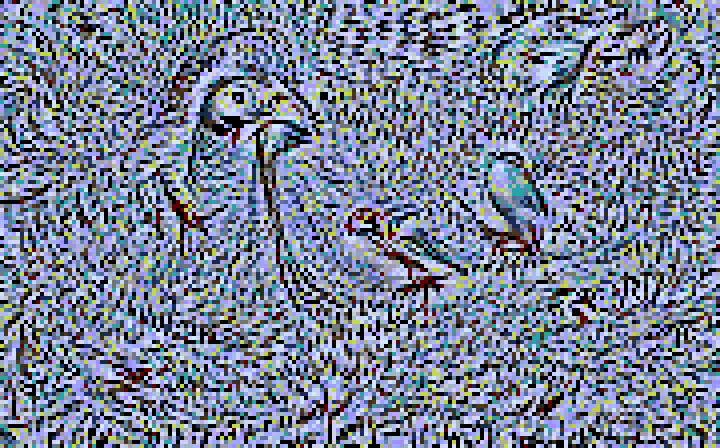

In [5]:
from IPython.display import Image

path_to_image = "images_out/default/default_1.png"
Image(path_to_image)

I see some hints of birds in that image, but mostly it's pretty chaotic. This is because we didn't give PyTTI much opportunity to generate an image for us, and we didn't provide an `init_image` as a starting place. Without an `init_image` the process defaults to initializing from random noise. This isn't necessarily a bad thing, but because we didn't give PyTTI time to do its thing, we mostly got random noise back out. Let's let it run a bit longer, say `steps_per_scene: 500` (the default was 50). 

To better understand how the step number affects the image, we'll tell PyTTI to show us the current state of the image periodically with `display_every: 50`: we're generating for 500 steps, so checking progress every 50 steps let's us see check in on our progress at 10% increments, which feels about right. For the purpose of this tutorial though, we'll suppress the output to the notebook with the `%%capture` command at the top of the cell and just look at the results after.

Just to make sure there's nothing unexpected in the defaults, I'll also suppress any animations by setting the `pre_animation_steps` to a value greater than or equal to our `steps_per_scene`. Also, that whole "default" namespace thing was confusing, so let's specify a namespace too.

In [6]:
%%writefile config/conf/my_first_pytti_art.yaml
# @package _global_
scenes: Everybody knows that the bird is the word

steps_per_scene: 500
save_every: 50
display_every: 50
pre_animation_steps: 500

file_namespace: bird
seed: 123

Overwriting config/conf/my_first_pytti_art.yaml


In [7]:
%%capture
!python -m pytti.workhorse conf=my_first_pytti_art

Just in case the image output is being finnicky, let's pull up those images here:

![50 steps](./images_out/bird/bird_1.png)
![100 steps](./images_out/bird/bird_2.png)
![150 steps](./images_out/bird/bird_3.png)
![200 steps](./images_out/bird/bird_4.png)
![250 steps](./images_out/bird/bird_5.png)
![300 steps](./images_out/bird/bird_6.png)
![350 steps](./images_out/bird/bird_7.png)
![400 steps](./images_out/bird/bird_8.png)
![450 steps](./images_out/bird/bird_9.png)

Great! We have some birds! ....and we also have a bunch of words. This isn't surprising: PyTTI likes to draw text into images, and also we had "word" in our prompt, biasing our image even more towards having "words" in it. But I don't want to see words, I just like that song lyric and want to see the AI draw birds. The bird is already "the word" (or haven't you heard?).

We can tell PyTTI we want a particular prompt to influence it more or less by applying a weight to the prompt. If we don't specify a weight, the default weight value is `1`. To try to get rid of the text in the image, let's try adding the prompt `"text:-1"` to our scene.

In [8]:
%%writefile config/conf/my_first_pytti_art.yaml
# @package _global_
scenes: Everybody knows that the bird is the word | text:-1

steps_per_scene: 500
#save_every: 500
#display_every: 500
pre_animation_steps: 500

file_namespace: bird2
seed: 123

Overwriting config/conf/my_first_pytti_art.yaml


In [9]:
%%capture
!python -m pytti.workhorse conf=my_first_pytti_art

Let's compare the same step from those two runs and see the difference:

![Text unsuppressed](./images_out/bird/bird_9.png)
![Text suppressed](./images_out/bird2/bird2_9.png)

Much Better! And quite difference! Obviously, the change we made affected the whole image, not just the text that was popping up. We can try to be more surgical with our modifications by using "semantic mask". The semantic mask is a prompt which PyTTI uses to score the image, and masks out the image where the semantic prompt doesn't match. We attach a semantic prompt with an underscore. Let's see if instead of "subtracting" the text from the image like we did before, we can convert it into something else. We've got birds already: let's try eggs. That feels on-theme.

In [10]:
%%writefile config/conf/my_first_pytti_art.yaml
# @package _global_
scenes: Everybody knows that the bird is the word | eggs in a nest_text

steps_per_scene: 500
#save_every: 500
#display_every: 500
pre_animation_steps: 500

file_namespace: bird3
seed: 123

Overwriting config/conf/my_first_pytti_art.yaml


In [11]:
%%capture
!python -m pytti.workhorse conf=my_first_pytti_art

![Text unsuppressed](./images_out/bird/bird_9.png)
![Text suppressed](./images_out/bird2/bird2_9.png)
![Text suppressed](./images_out/bird3/bird3_9.png)

Ok, so that sort of worked, but I liked the other way better. Let's try using both methods, but reduce the weight on each to try to let the original version of the image dominate a bit more.

In [16]:
%%writefile config/conf/my_first_pytti_art.yaml
# @package _global_
scenes: Everybody knows that the bird is the word:2 | eggs in a nest:.5_text | test:-.8

steps_per_scene: 500
#save_every: 500
#display_every: 500
pre_animation_steps: 500

file_namespace: bird4
seed: 123

Overwriting config/conf/my_first_pytti_art.yaml


In [17]:
%%capture
!python -m pytti.workhorse conf=my_first_pytti_art

![Text unsuppressed](./images_out/bird/bird_9.png)
![Text suppressed](./images_out/bird2/bird2_9.png)
![Text suppressed](./images_out/bird3/bird3_9.png)
![Text suppressed](./images_out/bird4/bird4_9.png)

Much better! I'm not really feeling the pixel art thing though: let's try switching from the default "Limited Palette" image model to `image_model: VQGAN` and see what that looks like. I'm feeling lazy though, so instead of modifying the config file like we were before, I'm just gonna use the same config from last time but override the `image_model` and `file_namespace` arguments directly from the command line.

In [18]:
%%capture
!python -m pytti.workhorse conf=my_first_pytti_art image_model=VQGAN file_namespace=bird5

![Text suppressed](./images_out/bird5/bird5_9.png)

As you can see, changing the image model doesn't just add realism: it basically changes everything. Bye bye nests, bye bye eggs, hello chicks? 

Moral of the story: your prompt-engineering will largely be image-model-dependent. Now that we've changed our image model, we need to re-tune our prompt for that model.